In [1]:
from generate_player_seasons import *

from multiprocessing import Pool

In [2]:
def get_path_ppg(G, node):
    
    points = []

    # points.append(G.nodes[node]['tp'])
    if G.nodes[node]['league'] == 'NHL':
        points.append(G.nodes[node]['ppg'])

    for n in sorted(nx.ancestors(G, node))[::-1]:
        if (n != 1) & (G.nodes[n]['league'] == 'NHL'):
            # points.append(G.nodes[n]['tp'])
            points.append(G.nodes[n]['ppg'])

        node=n

    ppg = round(np.mean(points),2)
    # return round(np.sum(points) / (64 * len(points)),2)
    return 0 if np.isnan(ppg) else ppg 

def get_player_role(G, dataset, position, floor_node, ceiling_node):

    role_order = { 'F' : {v : i for i,v in enumerate(f_role_labels)},
                  'D' : {v : i for i,v in enumerate(d_role_labels)},}

    nhl_stats = dataset[(dataset['league'] == 'NHL') &
              (dataset['season_age'].isin([i for i in range(19,25)]))].groupby(
        ['playerid','player', 'league', 'primary_position'])[['gp', 'tp']].sum().reset_index()

    nhl_stats['ppg'] = nhl_stats['tp'] / nhl_stats['gp']
    
    floor = get_path_ppg(G, floor_node)
    ceiling = get_path_ppg(G, ceiling_node)
    
    role_floor = get_role({'league' : 'NHL', 'ppg' : floor}, nhl_stats, position)
    role_ceiling = get_role({'league' : 'NHL', 'ppg' : ceiling}, nhl_stats, position)
    
    label = [role_order[position][i] for i in np.unique([role_floor, role_ceiling])]
    
    if len(label) > 1:
    
        text = '-'.join([list(role_order[position].keys())[list(role_order[position].values()).index(min(label))],
                         list(role_order[position].keys())[list(role_order[position].values()).index(max(label))]])
        text += f' {position}'
        
        return text
    
    else:

        text = list(role_order[position].keys())[list(role_order[position].values()).index(max(label))]
        text += f' {position}'
    
        return text
    
    return ''

In [3]:
import os 
from sqlalchemy import create_engine
def load_db_credentials():
    '''Load database credentials from bash_profile'''

    user = os.environ['db_user']
    password = os.environ['db_pass']
    server = os.environ['db_host']
    database = os.environ['db_name']

    return user, password, server, database

def predict_scoring(features, version=0):
    
    scoring_lstm = Model() 
    scoring_lstm.load_state_dict(torch.load(f'../models/boot_lstm_{version}.pth'))
    scoring_lstm.eval()

    return scoring_lstm(features).detach().numpy()
    

In [4]:
# load database credentials and create connection
user, password, server, database = load_db_credentials()
engine = create_engine(f'postgresql://{user}:{password}@{server}:5432/{database}')

In [5]:
# player_value = pd.read_sql(f'''select * from summary_projections where playerid = '{playerid}' ''', con=engine)
# projections = pd.read_sql(f'''select * from projections where playerid = '{playerid}' ''', con=engine)

In [31]:
player = GeneratePlayer()

In [62]:
playerid = '99204'
player.initialize_player(playerid, start_year=18)

In [63]:
player.simulate_player_development(node_counter=1)

In [64]:
player.generate_network_graph()

In [65]:
import sys
sys.path.append('../../apple-model-app/')

from helpers import *

In [66]:
G = player.G
df = player.dataset
position = player.position
player_name = player.player_name

In [67]:
# create tree layout and rescale based on age
pos = graphviz_layout(G, prog='dot')
# array of ages for y-axis
ages = np.arange(min([int(G.nodes[node]['age']) for node in G.nodes]),
             max([int(G.nodes[node]['age']) for node in G.nodes]) + 1,
             1)
# rescale x,y coordinates
y = np.array([xy[1] for _, xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

edge_labels = nx.get_edge_attributes(G, 'probability')

node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=["<b>" + G.nodes[g]['league'] for g in G.nodes],
    hovertemplate=
        "</b><b>%{customdata[1]}</b><br><br>" +
        "Age: <b>%{y:,.0f}</b><br>" +
        "League: %{text}</b><br>" +
        "PPG: <b>%{customdata[0]:,}</b>" +
        "<extra></extra>",
    customdata=[(round(G.nodes[g]['ppg'], 2), 
                 G.nodes[g]['role'])  for g in G.nodes],
    textposition='middle center',
    showlegend=True,
    # textfont=dict(size=14,),
    marker=dict(
#             color=[f'rgba(0, 116, 255, {d})' for d in d],
#             color=[G.nodes[g]['role_rank']  for g in G.nodes],
#         color=discrete_marker_color(df, G, position, n_bins=11),
        size= [30 for g in G.nodes],
        cmax=100,
        cmin=0,
        cmid=50,
        colorbar=dict(
            title="<b>Scoring Role<b> <br />",
            titleside="top",
            ticks='outside',
            showticklabels=True,
            tickvals=f_role_perc[:-1]  if position == 'F' else d_role_perc[:-1],
            ticktext=f_role_labels if position == 'F' else d_role_labels
        ),
        colorscale=custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, sep=1 , n=5), 5)
        )
)

fig = go.Figure(data=[node_trace, ],
             layout=go.Layout(
                #  height=600,
                #  width=900,
                title=f"<b>{player_name} Player Development</b>",
                # titlefont_size=18,
                font_color='black',
                 title_x=0.5,
                 plot_bgcolor='rgb(255,255,255)',
                 paper_bgcolor='rgba(0,0,0,0)',
                showlegend=False,
                hovermode='closest',
                margin=dict(b=30,l=0,r=0,t=30),
                annotations=[ dict(
                    text="By: Connor Jung <a href='https://twitter.com/ConnorJungle'>@ConnorJungle</a> Data Source: Elite Prospects",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.005 ) ],
                 yaxis=dict(title='<b>Season Age</b>', tickvals=ages, showline=True, linewidth=2, linecolor='black', mirror=True),
                xaxis=dict(showticklabels=False, title='MeaningleX Axis', showline=True, linewidth=2, linecolor='black', mirror=True),
             )
               )

for edge in G.edges():

    fig.add_annotation(
      x=(pos[edge[1]][0] + pos[edge[0]][0]) / 2,  # arrows' tail
      y=(pos[edge[1]][1] + pos[edge[0]][1]) / 2,  # arrows' tail
#         xanchor="right",
#         yanchor="bottom",
        showarrow=False,
        bordercolor="lightslategrey",
        borderwidth=2,
        borderpad=1,
      text= "{:.0%}".format(edge_labels[edge])
    )

    fig.add_annotation(
      x=pos[edge[1]][0],  # arrows' head
      y=pos[edge[1]][1],  # arrows' head
      ax=pos[edge[0]][0],  # arrows' tail
      ay=pos[edge[0]][1],  # arrows' tail
      xref='x1',
      yref='y1',
      axref='x1',
      ayref='y1',
        opacity=0.3,
      showarrow=True,
      arrowhead=3,
      arrowsize=1,
      arrowwidth=3,
      arrowcolor='lightslategrey',
        standoff = 15
    )

for y in np.unique([v[1] for k,v in pos.items()]):
    fig.add_shape(
            # Line Horizontal
                type="line",
                y0=y,
                x1=max([v[0] for k,v in pos.items()]) + (max([v[0] for k,v in pos.items()]) * 0.10) ,
                x0=min([v[0] for k,v in pos.items()]) - (max([v[0] for k,v in pos.items()]) * 0.10) ,
                y1=y,
                layer='below',
                line=dict(
                    color="rgba(212, 212, 212, 1)",
                    width=2,
                    dash="dashdot",
                ))

In [68]:
fig.show(config={"displayModeBar": False})

In [54]:
player.generate_league_season(player.player_df)
player_df = player.player_df.copy()

In [13]:
get_player_role(player.G,
                player.dataset,
                player.position,
                player.player_value['most_likely_nhl_node'],
                player.player_value['nhl_maximizing_node'])

'Top 6 F'

In [14]:
def get_nhl_path_ceiling(projections, G):
    nodes = projections[(projections.season_age == projections.season_age.max())].node
    max_points = 0
    max_node = 1
    for node in nodes:
        node_points = nhl_value(G, node)
        if node_points > max_points:
            max_points = node_points
            max_node = node
    ceiling_prob = round(node_probability(G, max_node),2)
    return dict(nhl_ceiling=round(max_points, 0), nhl_maximizing_node=max_node, nhl_ceiling_prob=float(ceiling_prob))

def get_nhl_path(projections, G):

    nodes = projections[(projections.season_age == projections.season_age.max())
                        & (projections.league=='NHL')].node

    probs = []
    max_prob = 0
    max_node = 1

    for node in nodes:
        node_prob = node_probability(G, node)
        if node_prob > max_prob:
            max_prob = node_prob
            max_node = node
        probs.append(node_prob)

    return dict(nhl_likelihood=round(sum(probs),2),
                    most_likely_nhl_node=max_node,
                    most_likely_nhl_prob=round(float(node_probability(G, max_node)),2),
                    nhl_floor=int(nhl_value(G, max_node))
                    )

In [15]:
get_nhl_path(player.projections, player.G)

{'nhl_likelihood': 1.0,
 'most_likely_nhl_node': 5,
 'most_likely_nhl_prob': 1.0,
 'nhl_floor': 130}

In [16]:
get_nhl_path_ceiling(player.projections, player.G)

{'nhl_ceiling': 130.0, 'nhl_maximizing_node': 5, 'nhl_ceiling_prob': 1.0}

In [9]:
import time

player.league_probs['scoring_distribution'] = [[] for _ in range(len(player.league_probs))]

for i, sim in player.league_probs.iterrows():
    start = time.time()
    # get next year data
    player_df['gp_y_plus_1'] = player_df.gp.shift(-1)
    player_df['league_y_plus_1'] = player_df.league.shift(-1)
    player_df.loc[player_df.gp_y_plus_1.isnull(), 'gp_y_plus_1'] = sim['gp']
    player_df.loc[player_df.league_y_plus_1.isnull(), 'league_y_plus_1'] = sim['league']

    print(round(time.time() - start), ' seconds after data prep')
    # prepare dataset for lstm
    features = prepare_features_single_season(player_df, 
                                            player.scoring_scaler, 
                                            'ppg_y_plus_1')

    # fill dummy values
    features[[col for col in player.scoring_features if col not in features.columns]] = 0

    # get the season index we want to extract
    current_season_index = features.shape[0] - 1

    print(round(time.time() - start), ' seconds after feature engineering')
    # pass player season sequences to lstm for prediction
    # start process to get predictions for all model versions create posterior distribution
    pool = Pool(processes=8)

    print(round(time.time() - start), ' seconds after creating multi process')

    sequence = features[player.scoring_features].values
    preds = [item[current_season_index].item() for item in 
                pool.starmap(predict_scoring, [(sequence, i) for i in range(100)])]
    
    pool.close()
    print(round(time.time() - start), ' seconds after prediction')

    player.league_probs.at[i, 'ppg'] = np.mean(preds)
    player.league_probs.at[i, 'scoring_distribution'] = preds
    print(round(time.time() - start), ' total seconds')

0  seconds after data prep
0  seconds after feature engineering
0  seconds after creating multi process
0  seconds after prediction
0  total seconds


In [153]:
def discrete_background_color_bins(df, n_bins=5, columns='all'):

    bounds = [i * (1.0 / n_bins) for i in range(n_bins + 1)]

    if columns == 'all':
        if 'id' in df:
            df_numeric_columns = df.select_dtypes('number').drop(['id'], axis=1)
        else:
            df_numeric_columns = df.select_dtypes('number')
    else:
        df_numeric_columns = df[columns]

    styles = []
    legend = []

    for column in df_numeric_columns:
        
        for i in range(1, len(bounds)):
            min_bound = np.percentile(df[column], bounds[i - 1] * 100)
            max_bound = np.percentile(df[column], bounds[i] * 100)
            backgroundColor = custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, n=n_bins), n_bins)[i - 1][1]
            color = 'black' 

            styles.append({
                'if': {
                    'filter_query': (
                        '{{{column}}} >= {min_bound}' +
                        (' && {{{column}}} < {max_bound}' if (i < len(bounds) - 1) else '')
                    ).format(column=column, min_bound=min_bound, max_bound=max_bound),
                    'column_id': column
                },
                'backgroundColor': backgroundColor,
                'color': color
            })

            legend.append(
                html.Div(style={'display': 'inline-block', 'width': '60px'}, children=[
                    html.Div(
                        style={
                            'backgroundColor': backgroundColor,
                            'borderLeft': '1px rgb(50, 50, 50) solid',
                            'height': '10px',
                        }
                    ),
                    html.Small(round(bounds[i - 1] * 100), style={'paddingLeft': '2px'})
                ])
            )

    return (styles, html.Div(legend, style={'padding': '5px 0 5px 0'}))


### lollipop graph

In [290]:
floor = player.player_value['nhl_floor'] 
ceiling = player.player_value['nhl_ceiling']

In [289]:
get_player_role(player.dataset, player.position, floor, ceiling)

'Elite F'

In [92]:
color_palette = custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, n=7), 7)

In [257]:
def get_potential_graph(player_df, floor, ceiling):

    try:
        nhl_pts = player_df.groupby('league').tp.sum()['NHL']

    except KeyError:
        nhl_pts = 0

    # Create a dataframe
    value1 = floor
    value2 = ceiling

    # Add title and axis names
    data = go.Scatter(
            x=[nhl_pts],
            y=[1],
            mode='markers',
            marker=dict(color='black', 
                       size=10)
        )

    x = [value1, value2]
    y_upper = [1]
    y_lower = [1]

    # annotations
    anno = [dict(x=value1,
            y=0,
            xref="x",
            yref="y",
            text="Floor",
            showarrow=True,
            font=dict(
                family="Overpass, monospace",
                size=16,
                color="black"
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor=color_palette[0][1],
            ax=30,
            ay=40,
            bordercolor=color_palette[0][1],
            borderwidth=2,
            borderpad=4,
            bgcolor=color_palette[0][1],
            opacity=0.8),
           dict(x=value2,
            y=2,
            xref="x",
            yref="y",
            text="Ceiling",
            showarrow=True,
            font=dict(
                family="Overpass, monospace",
                size=16,
                color="black"
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor=color_palette[-1][1],
            ax=-30,
            ay=-40,
            bordercolor=color_palette[-1][1],
            borderwidth=2,
            borderpad=4,
            bgcolor=color_palette[-1][1],
            opacity=0.8)]

    # Horizontal line shape
    shapes=[dict(
            type='line',
            x0 = value1,
            y0 = 2,
            x1 = value1,
            y1 = 0,
            line = dict(
                color =color_palette[0][1],
                width = 10
            )
    ),
            dict(
            type='line',
            x0 = value2,
            y0 = 2,
            x1 = value2,
            y1 = 0,
            line = dict(
                color =color_palette[-1][1],
                width = 10
            )
    ),
            dict(
            type='line',
            x0 = -25,
            y0 = 1,
            x1 = 0,
            y1 = 1,
            line = dict(
                color ='black',
                width = 3
            )
    ),
            dict(
            type='line',
            x0 = nhl_pts + 5,
            y0 = 1,
            x1 = value1,
            y1 = 1,
            line = dict(
                color =color_palette[0][1],
                width = 3,
                dash="dashdot"
            )
    ),
            dict(
            type='line',
            x0 = max([value1, nhl_pts]) + 5,
            y0 = 1,
            x1 = value2,
            y1 = 1,
            line = dict(
                color =color_palette[-1][1],
                width = 3,
                dash="dashdot"
            )
    )
           ]


    layout = go.Layout(
        shapes = shapes,
        annotations=anno,
        xaxis = dict(title='NHL Points',range=[-25, max([value2, nhl_pts]) + 25], autorange=False, ticks='outside',  showline=True, linewidth=2, linecolor='black', mirror=True),
        yaxis = dict(range=[-0.5, 2.5],  showline=True, linewidth=2, linecolor='black', mirror=True, showticklabels=False,),
        plot_bgcolor='rgb(255,255,255)',
        showlegend=False,
        hovermode='closest',
    )

    # Plot the chart
    fig = go.Figure(data=[data],
                    layout=layout
                   )

    return fig


### Player Cards

In [294]:
[player.G.nodes[g]['role_rank']  for g in player.G.nodes]

[100, 85, 99, 82, 95, 87, 97, 97, 99]

### NHL path maximization

In [82]:
def get_nhl_path(self):

    nodes = self.projections[(self.projections.season_age==23)
                              & (self.projections.league=='NHL')].node

    probs = []
    max_prob = 0
    max_node = 1
    
    for node in nodes:
        node_prob = node_probability(self.G, node)
        if node_prob > max_prob:
            max_prob = node_prob
            max_node = node
        probs.append(node_prob)
        
    return dict(nhl_likelihood=round(sum(probs),2), most_likelihood_nhl_node=max_node)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['tp'] * G.nodes[n]['cond_prob']\
                   for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

def get_nhl_value(self):

    nodes = self.projections[(self.projections.start_node==1)].node
        
    return dict(nhl_expected_value=round(sum([nhl_expected_value(self.G, n) for n in nodes]),2))

In [98]:
player_value = dict(playerid = player.playerid,
                    player_name = player.player_name)

player_value.update(get_nhl_path(player))

player_value.update(get_nhl_value(player))

self.player_value = player_value

# Debugging

In [73]:
player.projections[player.projections.league == 'NHL']

,playerid,player,season_age,start_league,league,probability,gp,ppg,gpg,apg,perc_team_a,perc_team_g,perc_team_tp,start_node,node,epoints,nhl_xvalue,xvalue,cond_probability
1,496724,Bobby Brink,20.0,NCAA,NHL,0.098301,82.0,0.540381,0.270190,0.270190,0.055838,0.089469,0.068094,1,3,44.311219,126.0,8.684999,0.098000
2,496724,Bobby Brink,21.0,NCAA,NHL,0.063941,82.0,0.946245,0.473122,0.473122,0.091804,0.149281,0.112452,2,6,77.592086,59.1,13.437708,0.057728
0,496724,Bobby Brink,21.0,NHL,NHL,0.888651,82.0,1.317420,0.658710,0.658710,0.123917,0.203812,0.152375,3,7,108.028440,94.7,28.234961,0.087122
2,496724,Bobby Brink,22.0,NCAA,NHL,0.156823,82.0,1.251578,0.625789,0.625789,0.119374,0.195529,0.146527,4,11,102.629384,59.5,42.903652,0.104511
1,496724,Bobby Brink,22.0,AHL,NHL,0.207605,82.0,1.008226,0.504113,0.504113,0.098320,0.159778,0.120353,5,13,82.674515,21.1,12.284761,0.037148
0,496724,Bobby Brink,22.0,NHL,NHL,1.000000,82.0,1.387374,0.693687,0.693687,0.131123,0.215479,0.161133,6,15,113.764642,32.8,26.269621,0.057728
0,496724,Bobby Brink,22.0,NHL,NHL,1.000000,82.0,1.545481,0.772741,0.772741,0.144803,0.238708,0.178139,7,16,126.729478,50.6,44.163702,0.087122
1,496724,Bobby Brink,22.0,AHL,NHL,0.196520,82.0,1.073093,0.536547,0.536547,0.103932,0.169308,0.127330,8,18,87.993660,1.2,0.754270,0.002143
1,496724,Bobby Brink,23.0,NCAA,NHL,0.338776,82.0,1.178850,0.589425,0.589425,0.113402,0.185300,0.139095,9,21,96.665675,0.0,56.607275,0.117120
1,496724,Bobby Brink,23.0,AHL,NHL,0.255297,82.0,0.933181,0.466591,0.466591,0.092147,0.149208,0.112672,10,24,76.520856,0.0,21.042528,0.054998


### Prepare NetworkX df

In [101]:
df = player.projections.copy().round(3)
df['start_age'] = df.season_age - 1
df['weight'] = df.probability
df['epoints'] = df['ppg'] * df['gp']

### Using NetworkX to assign Simulated Seasons in Graphs

Text(0.125, 0.05, 'By: Connor Jung @ConnorJungle, Data Source: Elite Prospects')

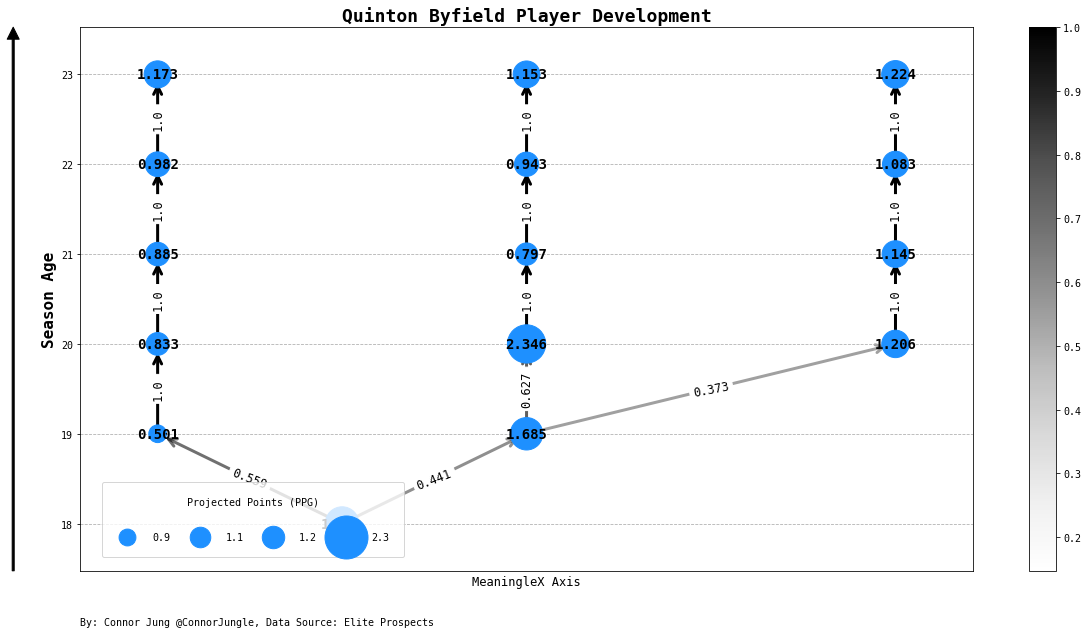

In [9]:
matplotlib.rc('font',family='monospace')

fig, ax = plt.subplots(figsize=(20,10))

# create tree layout and rescale based on age
pos = graphviz_layout(player.G, prog='dot')
# array of ages for y-axis
ages = np.arange(player.start_age,
                 player.projections.season_age.astype(int).max() + 1,
                 1)
# rescale x,y coordinates
y = np.array([xy[1] for _, xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

node_sizes = [player.G.nodes[g]['ppg'] / player.position_ppg[player.position] * 300 for g in player.G.nodes]
player.node_sizes = node_sizes

# draw nodes
nodes = nx.draw_networkx_nodes(player.G,
                               pos,
                               node_size=node_sizes,
                               node_color='dodgerblue',
                               ax=ax)
node_labels = nx.get_node_attributes(player.G, 'ppg')
nx.draw_networkx_labels(player.G,
                        pos,
                        node_labels,
                        font_size=14,
                        ax=ax, 
                        font_family='monospace', 
                        font_color='black', 
                        font_weight='bold',)

# draw edges
edges = nx.draw_networkx_edges(player.G,
                               pos, 
                               arrowstyle='->', 
                               arrowsize=20, 
                               edge_cmap=plt.cm.Greys, 
                               width=3,
                               ax=ax)
edge_labels = nx.get_edge_attributes(player.G, 'probability')
nx.draw_networkx_edge_labels(player.G, 
                             pos, 
                             edge_labels, 
                             font_size=12,
                             ax=ax, 
                             font_family='monospace')

# set alpha value for each edge
for i in range(len(player.projections)):
    edges[i].set_alpha(player.projections.probability.values[i])

# colourscale for colourbar
pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Greys)
pc.set_array([(5 + i) / (30 + 4) for i in range(30)])
plt.colorbar(pc)
# create legend for projected points
custom_leg = [mlines.Line2D([0], [0], marker='o', color='dodgerblue', linestyle='None') for _ in range(0,5)]
# 4 part distirubtion
Q1 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 25, interpolation = 'midpoint').round(1) 
Q2 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 50, interpolation = 'midpoint').round(1) 
Q3 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 75, interpolation = 'midpoint').round(1)
Q4 = np.percentile([player.G.nodes[g]['ppg'] for g in player.G.nodes], 100, interpolation = 'midpoint').round(1)
point_range=[Q1, Q2, Q3, Q4]
player.point_range = point_range
custom_leg = [mlines.Line2D([0], [0],
                            marker='o',
                            color='dodgerblue',
                            markersize=point_range[i] / player.position_ppg[player.position] * 9 ,
                            linestyle='None') for i in range(0,4)]
leg = plt.legend(custom_leg, point_range,
                 title = 'Projected Points (PPG)',
#                  markerscale=30,
                 labelspacing=2.5,
                 handletextpad=1.5,
                 borderpad=1.5,
                 ncol=4,
                 loc=(0.025, .025))

ax.annotate('', xytext=(-.075, 0),  xy=(-.075, 1),  xycoords='axes fraction', arrowprops=dict(color='black', width=2))

# axis changes
ax.set_yticks(ages)
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
ax.set_ylabel('Season Age', size=16, weight='bold')
ax.set_xlabel('MeaningleX Axis', size=12)
plt.gca().yaxis.grid(True, linestyle='--',)
plt.title(f"{player.player_name} Player Development", fontsize=18, fontweight='bold')
footnote = """By: Connor Jung @ConnorJungle, Data Source: Elite Prospects"""
plt.figtext(0.125, 0.05, footnote)

In [94]:
def nhl_expected_value(G, node):
    
    value = []
    for n in nx.descendants(G, node):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

for i, n in enumerate(player.G.nodes):
    print(i+1, nhl_expected_value(player.G, n))

1 262.423
2 150.92999999999998
3 98.011
4 33.326
5 74.447
6 2.857
7 62.615
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0


In [99]:
62.615 + 2.857  + 33.326

98.798

In [42]:
def node_probability(G, node):
    
    probabilities = []
    for n in sorted(nx.ancestors(G, node))[::-1]:
        probabilities.append(G.edges[(n, node)]['probability'])
        node=n
    return np.prod(probabilities)

def node_expected_value(G, node):

    return sum(G.nodes[node]['epoints'] * G.nodes[node]['cond_prob'] for n in nx.ancestors(G, node) | {node})

def nhl_expected_value(G, node):
    
    value = []
    for n in sorted(nx.descendants(G, node)):
        value.append(G.nodes[n]['xvalue'] if G.nodes[n]['league'] == 'NHL' else 0)
    return np.sum(value)

def nhl_expected_value(G, node):
        
    return np.sum([G.nodes[n]['xvalue'] for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

In [137]:
df = df.assign(nhl_xvalue=np.nan,xvalue=np.nan,cond_probability=np.nan,)
for node in df.node:
    df.loc[df.node == node, ['nhl_xvalue']] = node_expected_value(G, node)
    df.loc[df.node == node, ['xvalue']] = nhl_expected_value(G, node)
    df.loc[df.node == node, ['cond_probability']] = node_probability(G, node)

Node 2 xV: 124.17275200000002
Node 3 xV: 15.551628000000001
Node 4 xV: 42.511720020000006
Node 5 xV: 74.86334856000002
Node 6 xV: 32.917013999999995
Node 7 xV: 58.35763208
Node 8 xV: 14.75639497332
Node 9 xV: 48.53716051184
Node 10 xV: 33.473712000000006


### Linear Model for Team Percentage of Scoring

In [76]:
import pandas as pd

df = pd.read_csv('../data/player_season_stats_v3.csv')
X, y, _ = prepare_features(df, 'ppg_y_plus_1')

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

def fit_team_scoring_model(data, scoring_metric):
    
    df = get_next_season_data(data)

    df = df[(df.gp < 85)
        & (df.gp > 30)
        & (df.season_age >= 17)
        & (df.season_age <= 24)
        & (df.gp_y_plus_1.notnull())]
    
    age = pd.DataFrame(df.season_age)
    
    df = df.set_index(['playerid', 'player', 'season_age'])
    
    age.index = df.index
    
    features = df[[scoring_metric]].merge(
        pd.get_dummies(df['league'], drop_first=True),
        left_index=True,
        right_index=True).merge(
        pd.get_dummies(age.season_age, drop_first=True),
        left_index=True,
        right_index=True)
    
    label = 'perc_team_tp' if scoring_metric == 'ppg' \
    else 'perc_team_g' if scoring_metric == 'gpg'\
    else 'perc_team_a' 
    
    print(features.shape)
    
    target = df[label]

    lin_model = LinearRegression()

    lin_model.fit(features[target.notnull().values], target[target.notnull().values])

    print('Mean Absolute Error: ', mean_absolute_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    print('Mean Squared Error: ', mean_squared_error(target[target.notnull().values],
                                                       lin_model.predict(features[target.notnull().values])))

    sns.distplot(target[target.notnull().values])
    plt.show()

    plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
           axisbelow=True, grid=True,
          )
    plt.rc('grid', color='grey', linestyle='dashed')
    plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

    plt.figure(figsize=(10,5),facecolor="#ffffff")

    slope, intercept, r_value, p_value, std_err = stats.linregress(lin_model.predict(features[target.notnull().values]),
                                                                   target[target.notnull().values])

    sns.regplot(x = lin_model.predict(features[target.notnull().values]),
                y = target[target.notnull().values],
                line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                               intercept,
                                                                                               p_value, 
                                                                                               r_value ** 2)})
    plt.title('Predicting Percentage of Team TP [Full LR]')
    plt.legend()
    plt.show()
    
    joblib.dump(lin_model, f'../models/{scoring_metric}_team_model.pkl')
    
    return features

(68936, 35)
Mean Absolute Error:  0.008144816851405647
Mean Squared Error:  0.00013299582806643843


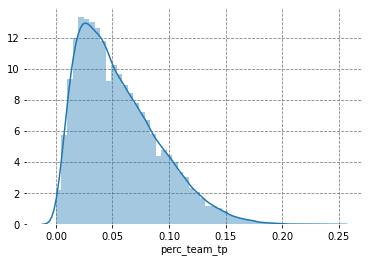

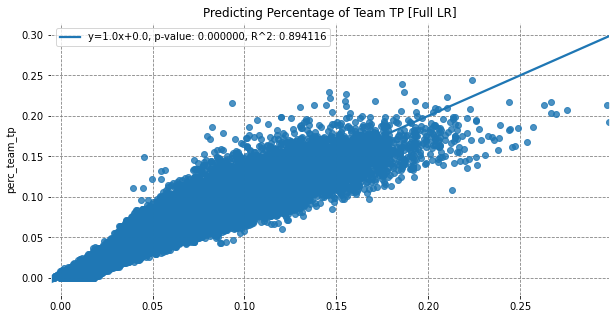

(68936, 35)
Mean Absolute Error:  0.00840731749713245
Mean Squared Error:  0.00014379513080150111


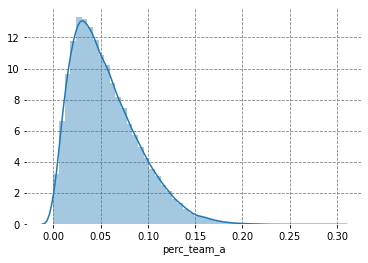

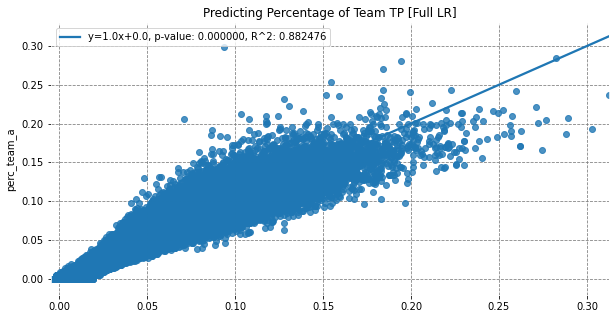

(68936, 35)
Mean Absolute Error:  0.008483355596414307
Mean Squared Error:  0.00015962756766618228


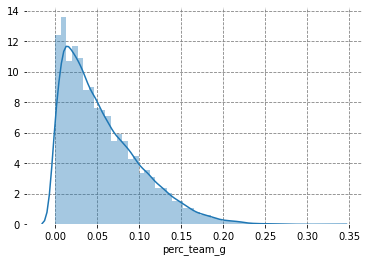

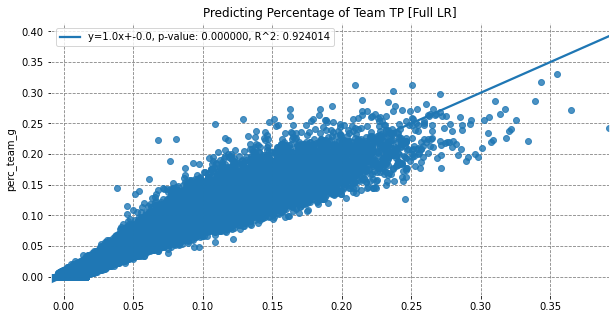

In [78]:
metric = ['ppg', 'apg', 'gpg']
for met in metric:
    feats = fit_team_scoring_model(df, met)

In [236]:
def get_primary_position(val):

    match = re.search('[c,w,lw,rw,f]', val.lower())

    if match:
        return 'F'
    else:
        return 'D'

In [237]:
data = player.dataset
data['primary_position'] = data.position.apply(get_primary_position)

In [243]:
def scoring_by_position(self):
    
    data = player.dataset
    
    data['primary_position'] = data.position.apply(get_primary_position)
    
    self.position_ppg = data[(data.season_age >= 17)
                             & (data.season_age <= 23)].groupby('primary_position').ppg.mean().to_dict()



# Plotly NxGraph

In [783]:
import plotly.graph_objects as go
from scipy import stats
import networkx as nx

G = nx.random_geometric_graph(200, 0.125)

In [963]:
# create tree layout and rescale based on age
pos = graphviz_layout(player.G, prog='dot')
# array of ages for y-axis
ages = np.arange(player.start_age,
                 player.projections.season_age.astype(int).max() + 1,
                 1)
# rescale x,y coordinates
y = np.array([xy[1] for _, xy in pos.items()])
y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}

node_sizes = [player.G.nodes[g]['ppg'] / player.position_ppg[player.position] * 300 for g in player.G.nodes]
player.node_sizes = node_sizes

# draw nodes
nodes = nx.draw_networkx_nodes(player.G,
                               pos,
                               node_size=node_sizes,
                               node_color='dodgerblue',
                               ax=ax)
node_labels = nx.get_node_attributes(player.G, 'ppg')
nx.draw_networkx_labels(player.G,
                        pos,
                        node_labels,
                        font_size=14,
                        ax=ax, 
                        font_family='monospace', 
                        font_color='black', 
                        font_weight='bold',)

# draw edges
edges = nx.draw_networkx_edges(player.G,
                               pos, 
                               arrowstyle='->', 
                               arrowsize=20, 
                               edge_cmap=plt.cm.Greys, 
                               width=3,
                               ax=ax)
edge_labels = nx.get_edge_attributes(player.G, 'probability')
nx.draw_networkx_edge_labels(player.G, 
                             pos, 
                             edge_labels, 
                             font_size=12,
                             ax=ax, 
                             font_family='monospace')


{(1.0, 1.0): Text(3.8333333333333335, 18.0, 'nan'),
 (1.0, 2.0): Text(2.738095238095238, 18.5, '0.559'),
 (1.0, 3.0): Text(4.928571428571429, 18.5, '0.441'),
 (2.0, 4.0): Text(1.6428571428571428, 19.5, '1.0'),
 (3.0, 5.0): Text(6.023809523809524, 19.5, '0.627'),
 (3.0, 6.0): Text(8.214285714285715, 19.5, '0.373'),
 (4.0, 7.0): Text(1.6428571428571428, 20.5, '1.0'),
 (5.0, 8.0): Text(6.023809523809524, 20.5, '1.0'),
 (6.0, 9.0): Text(10.404761904761905, 20.5, '1.0'),
 (7.0, 10.0): Text(1.6428571428571428, 21.5, '1.0'),
 (8.0, 11.0): Text(6.023809523809524, 21.5, '1.0'),
 (9.0, 12.0): Text(10.404761904761905, 21.5, '1.0'),
 (10.0, 13.0): Text(1.6428571428571428, 22.5, '1.0'),
 (11.0, 14.0): Text(6.023809523809524, 22.5, '1.0'),
 (12.0, 15.0): Text(10.404761904761905, 22.5, '1.0')}

In [428]:
edge_x = []
edge_y = []
for edge in player.G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color=f'rgba(30, 117, 255, 1)'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
labels = []
for node in player.G.nodes():
    x, y = pos[node]
    labels.append("<b>" + nx.get_node_attributes(player.G, 'league')[node]) 
    node_x.append(x)
    node_y.append(y)


In [35]:
def get_development_graph(player):
    
    # create tree layout and rescale based on age
    pos = graphviz_layout(player.G, prog='dot')
    # array of ages for y-axis
    ages = np.arange(player.start_age,
                     player.projections.season_age.astype(int).max() + 1,
                     1)
    # rescale x,y coordinates
    y = np.array([xy[1] for _, xy in pos.items()])
    y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
    y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
    pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}
    
    edge_labels = nx.get_edge_attributes(player.G, 'probability')
    
    node_trace = go.Scatter(
        x=[pos[node][0] for node in player.G.nodes()],
        y=[pos[node][1] for node in player.G.nodes()],
        mode='markers+text',
        text=["<b>" + player.G.nodes[g]['league'] for g in player.G.nodes],
        hovertemplate=
            "</b><b>%{customdata[1]}</b><br><br>" +
            "Age: <b>%{y:,.0f}</b><br>" +
            "League: %{text}</b><br>" +
            "PPG: <b>%{customdata[0]:,}</b>" +
            "<extra></extra>",
        customdata=[(round(player.G.nodes[g]['ppg'], 2), 
                     player.G.nodes[g]['role'])  for g in player.G.nodes],
        textposition='middle center',
        showlegend=True,
        textfont=dict(size=14,),
        marker=dict(
#             color=[f'rgba(0, 116, 255, {d})' for d in d],
            color=[player.G.nodes[g]['role_rank']  for g in player.G.nodes],
            size= [(player.G.nodes[g]['role_rank'] / 50) * 20 for g in player.G.nodes],
            cmax=100,
            cmin=0,
            cmid=30,
            colorbar=dict(
                title="<b>Scoring Role<b> <br />",
                titleside="top",
                ticks='outside',
                showticklabels=True,
                tickvals=[29, 49, 74, 89, 95],
                ticktext=['Depth', 'Top 9', 'Top 6', 'Top Line', 'Elite']
            ),
            colorscale='rdbu'
            )
    )

    legend = go.Scatter(x=[None], y=[None],
                       marker=dict(
            size=0,
            cmax=1,
            cmin=0,
            color=[0,1],
            colorbar=dict(
                title="<b>Transition %<b> <br />",
                titleside="top",
            ),
            colorscale="Greys"
        ),
                        showlegend=True,
        mode="markers")

    fig = go.Figure(data=[node_trace, ],
                 layout=go.Layout(
                     font=dict(family='overpass, monospace') , 
                    title=f"<b>{player.player_name} Player Development</b>",
                    titlefont_size=18,
                     title_x=0.5,
                     plot_bgcolor='rgb(255,255,255)',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="By: Connor Jung <a href='https://twitter.com/ConnorJungle'>@ConnorJungle</a> Data Source: Elite Prospects",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.005 ) ],
                     yaxis=dict(title='<b>Season Age</b>', showline=True, linewidth=2, linecolor='black', mirror=True),
                    xaxis=dict(showticklabels=False, title='MeaningleX Axis', showline=True, linewidth=2, linecolor='black', mirror=True),
                 )
                   )

    for edge in player.G.edges():

        fig.add_annotation(
          x=(pos[edge[1]][0] + pos[edge[0]][0]) / 2,  # arrows' tail
          y=(pos[edge[1]][1] + pos[edge[0]][1]) / 2,  # arrows' tail
    #         xanchor="right",
    #         yanchor="bottom",
            showarrow=False,
            bordercolor="lightslategrey",
            borderwidth=2,
            borderpad=1,
          text= "{:.0%}".format(edge_labels[edge])
        )

        fig.add_annotation(
          x=pos[edge[1]][0],  # arrows' head
          y=pos[edge[1]][1],  # arrows' head
          ax=pos[edge[0]][0],  # arrows' tail
          ay=pos[edge[0]][1],  # arrows' tail
          xref='x1',
          yref='y1',
          axref='x1',
          ayref='y1',
            opacity=0.3,
          showarrow=True,
          arrowhead=3,
          arrowsize=1,
          arrowwidth=3,
          arrowcolor='lightslategrey',
            standoff = 15
        )

    for y in np.unique([v[1] for k,v in pos.items()]):
        fig.add_shape(
                # Line Horizontal
                    type="line",
                    y0=y,
                    x1=max([v[0] for k,v in pos.items()]) + (max([v[0] for k,v in pos.items()]) * 0.10) ,
                    x0=min([v[0] for k,v in pos.items()]) - (max([v[0] for k,v in pos.items()]) * 0.10) ,
                    y1=y,
                    layer='below',
                    line=dict(
                        color="rgba(212, 212, 212, 1)",
                        width=2,
                        dash="dashdot",
                    ))

    
    return fig.show(config = {'displayModeBar': False})

In [36]:
get_development_graph(player)

In [796]:
subset = player.dataset.loc[(player.dataset.gp >= 20)
                            & (player.dataset.league == row['league'])
                            & (player.dataset.primary_position == player.position), ['ppg']]

In [800]:
def get_role(row):
    
    subset = player.dataset.loc[(player.dataset.gp >= 20)
                                & (player.dataset.league == row['league'])
                                & (player.dataset.primary_position == player.position), ['ppg']]
    
    if player.position == 'D':
        return np.where(row['ppg'] > np.percentile(subset.ppg, 20),
                        np.where(row['ppg'] > np.percentile(subset.ppg, 50),
                                 np.where(row['ppg'] > np.percentile(subset.ppg, 70),
                                          np.where(row['ppg'] > np.percentile(subset.ppg, 85),
                                                   'Elite',
                                                   'Top Pair'
                                                  ),
                                          'Top 4'
                                         ),
                                 'Top 6'
                                ),
                        'Depth'
                       )
    
    else:
        return np.where(row['ppg'] > np.percentile(subset.ppg, 30),
                        np.where(row['ppg'] > np.percentile(subset.ppg, 50),
                                 np.where(row['ppg'] > np.percentile(subset.ppg, 75),
                                          np.where(row['ppg'] > np.percentile(subset.ppg, 90),
                                                   'Elite',
                                                   'Top Line'
                                                  ),
                                          'Top 6'
                                         ),
                                 'Top 9'
                                ),
                        'Depth'
                       )
    
def get_role_rank(row):
    
    subset = player.dataset.loc[(player.dataset.gp >= 20)
                                & (player.dataset.league == row['league'])
                                & (player.dataset.primary_position == player.position), ['ppg']]
    
    return round(stats.percentileofscore(subset.ppg, row['ppg'], kind='strict'))
    

In [32]:
from matplotlib import cm
import matplotlib

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = np.array(cmap(k*h)[:3])*255
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

colorscale = cm.get_cmap('RdBu_r')
scale_rgb = []

norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
    k = matplotlib.colors.colorConverter.to_rgb(colorscale(norm(i)))
    scale_rgb.append(k)

RdBu_r = matplotlib_to_plotly(colorscale, 255)

